In [ ]:
# Temporal XGBoost (practical implementation)
# Paste into a Jupyter / Colab / Kaggle notebook and run.
# Requires: numpy, pandas, xgboost, sklearn, matplotlib (optional for plots).

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ----------------------------
# 1) Example: generate small synthetic multi-series dataset
# ----------------------------
def generate_synthetic_series(n_series=600, n_time=120, seed=42):
    np.random.seed(seed)
    rows = []
    for s in range(n_series):
        ar1 = 0.4 + 0.1*np.random.randn()
        ar2 = -0.2 + 0.05*np.random.randn()
        eps = np.random.randn(n_time) * 0.02
        y = np.zeros(n_time)
        exog = np.sin(np.linspace(0, 4*np.pi, n_time) + np.random.rand()) * 0.01 + 0.005*np.random.randn(n_time)
        for t in range(2, n_time):
            y[t] = ar1*y[t-1] + ar2*y[t-2] + 0.1*exog[t-1] + eps[t]
        df = pd.DataFrame({
            "series": f"S{s}",
            "time": np.arange(n_time),
            "y": y,
            "exog": exog
        })
        rows.append(df)
    return pd.concat(rows).reset_index(drop=True)

df = generate_synthetic_series(n_series=6, n_time=120)
# target: next-step y
df['y_target'] = df.groupby('series')['y'].shift(-1)
df = df.dropna().reset_index(drop=True)

# ----------------------------
# 2) Helpers: build lag index / per-series AR coefficients / heteroskedastic weights
# ----------------------------
def build_lag_index_matrix(df, series_col='series', max_k=3):
    df2 = df.reset_index(drop=True)
    n = len(df2)
    lag_idx = np.full((n, max_k), -1, dtype=int)
    grouped = df2.groupby(series_col).apply(lambda g: g.index.values)
    for s, positions in grouped.items():
        for pos_idx, global_idx in enumerate(positions):
            for lag in range(1, max_k+1):
                src_pos = pos_idx - lag
                if src_pos >= 0:
                    lag_idx[global_idx, lag-1] = positions[src_pos]
    return lag_idx

def estimate_per_series_ar(df, y_col='y', series_col='series', k=3):
    ar_map = {}
    for s, g in df.groupby(series_col):
        y = g[y_col].values
        if len(y) <= k+5:
            ar_map[s] = np.zeros(k)
            continue
        Y = y[k:]
        X = np.column_stack([y[k - i - 1: len(y) - i - 1] for i in range(k)])
        coeffs, *_ = np.linalg.lstsq(X, Y, rcond=None)
        ar_map[s] = coeffs
    return ar_map

def per_sample_ar_matrix(df, ar_map, k):
    ar_mat = np.zeros((len(df), k))
    for i, s in enumerate(df['series']):
        ar_mat[i, :] = ar_map.get(s, np.zeros(k))
    return ar_mat

def volatility_weights(df, y_col='y', series_col='series', window=10, min_w=0.6, max_w=1.4):
    w = np.ones(len(df), dtype=float)
    for s, g in df.groupby(series_col):
        vol = g[y_col].rolling(window).std().fillna(method='bfill').values
        inv = 1.0 / (1.0 + vol)
        a = (inv - inv.min()) / (inv.max() - inv.min() + 1e-9)
        w_s = min_w + a * (max_w - min_w)
        w[g.index.values] = w_s
    return w

# ----------------------------
# 3) Build features (lag features + exogenous)
# ----------------------------
MAX_K = 3
lag_idx = build_lag_index_matrix(df, max_k=MAX_K)
ar_map = estimate_per_series_ar(df, y_col='y', k=MAX_K)
ar_coeffs_mat = per_sample_ar_matrix(df, ar_map, MAX_K)
weights = volatility_weights(df, y_col='y', window=10)

def build_features(df, max_k=3):
    X = pd.DataFrame(index=df.index)
    X['y'] = df['y'].values
    X['exog'] = df['exog'].values
    for lag in range(1, max_k+1):
        X[f'lag_{lag}'] = df['y'].shift(lag).fillna(0).values
    X['roll_mean_5'] = df.groupby('series')['y'].transform(lambda x: x.rolling(5).mean().fillna(method='bfill'))
    return X.fillna(0).values

X = build_features(df, MAX_K)
y = df['y_target'].values

# ----------------------------
# 4) Train/test indices (time-based)
# ----------------------------
def time_train_test_idx(df, series_col='series', test_frac=0.2):
    train_idx = []
    test_idx = []
    for s, g in df.groupby(series_col):
        n = len(g)
        cut = int(n*(1-test_frac))
        inds = g.index.values
        train_idx.extend(inds[:cut].tolist())
        test_idx.extend(inds[cut:].tolist())
    return np.array(sorted(train_idx)), np.array(sorted(test_idx))

train_idx, test_idx = time_train_test_idx(df, test_frac=0.2)

# ----------------------------
# 5) Baseline: vanilla XGBoost
# ----------------------------
dtrain_v = xgb.DMatrix(X[train_idx], label=y[train_idx], weight=weights[train_idx])
dtest_v  = xgb.DMatrix(X[test_idx], label=y[test_idx], weight=weights[test_idx])
params = {'objective':'reg:squarederror', 'eta':0.1, 'max_depth':4, 'verbosity':0, 'seed':42}
bst_v = xgb.train(params, dtrain_v, num_boost_round=100, evals=[(dtest_v, 'test')], verbose_eval=False)
pred_v = bst_v.predict(dtest_v)
rmse_v = np.sqrt(mean_squared_error(y[test_idx], pred_v))

# ----------------------------
# 6) Temporal objective: AR penalty
# ----------------------------
def make_temporal_obj(lag_idx, ar_coeffs_mat, lambda_per_sample, weights=None):
    n, k = lag_idx.shape
    def obj(preds, dtrain):
        y_true = dtrain.get_label()
        preds = preds.astype(float)
        ar_pred = np.zeros_like(preds)
        for i in range(k):
            idx = lag_idx[:, i]
            valid = idx >= 0
            if valid.any():
                ar_pred[valid] += ar_coeffs_mat[valid, i] * preds[idx[valid]]
        temp_resid = preds - ar_pred
        fit_resid = preds - y_true
        lam = lambda_per_sample
        if weights is None:
            w = 1.0
        else:
            w = weights
        grad = 2.0 * w * (fit_resid + lam * temp_resid)
        hess = 2.0 * w * (1.0 + lam)
        return grad, hess
    return obj

# We'll train on the full DMatrix but only effective where sample weight>0 (train rows)
full_weights = np.zeros(len(df))
full_weights[train_idx] = weights[train_idx]
dall = xgb.DMatrix(X, label=y, weight=full_weights)

lambda_pooled = 0.05
lambda_full = np.ones(len(df)) * lambda_pooled
obj = make_temporal_obj(lag_idx, ar_coeffs_mat, lambda_full, weights=full_weights)
params_t = {'eta':0.1, 'max_depth':4, 'verbosity':0, 'seed':42}
bst_t = xgb.train(params_t, dall, num_boost_round=100, obj=obj, verbose_eval=False)

# eval on test
dtest_t = xgb.DMatrix(X[test_idx], label=y[test_idx], weight=weights[test_idx])
pred_t = bst_t.predict(dtest_t)
rmse_t = np.sqrt(mean_squared_error(y[test_idx], pred_t))

print("Vanilla RMSE:", rmse_v)
print("Temporal RMSE:", rmse_t)

# ----------------------------
# 7) Quick lambda sweep (example)
# ----------------------------
lambdas = [0.0, 0.01, 0.05, 0.1, 0.2]
scores = []
for lam in lambdas:
    lambda_full = np.ones(len(df)) * lam
    obj = make_temporal_obj(lag_idx, ar_coeffs_mat, lambda_full, weights=full_weights)
    bst_tmp = xgb.train(params_t, dall, num_boost_round=60, obj=obj, verbose_eval=False)
    pred_tmp = bst_tmp.predict(dtest_t)
    scores.append(np.sqrt(mean_squared_error(y[test_idx], pred_tmp)))

print("Lambda vs RMSE:")
for lam, s in zip(lambdas, scores):
    print(f" lambda={lam:.3f} -> RMSE={s:.6f}")

# ----------------------------
# 8) How to extend this demo into the full system you described:
# - Per-series lambda: create lambda_per_series dict and then lambda_full array mapping each row to its series lambda.
#   Learn lambda per-series by grid-search on validation folds (or cluster series for efficiency).
# - Multi-scale: duplicate feature-building with different histories (short features: small lags; long features: longer rolling stats),
#   train bst_short and bst_long with their own lag_idx/ar coefficients/lambda, combine additively: pred = pred_short + pred_long.
# - MA component: run an iterative loop: train model -> compute residuals -> add residual_lag features -> retrain a couple of iterations.
# - Interpretability: compute preds_short/preds_long and show contributions; use SHAP TreeExplainer on each model for feature-level attribution.


/tmp/ipython-input-1705177157.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df2.groupby(series_col).apply(lambda g: g.index.values)
/tmp/ipython-input-1705177157.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vol = g[y_col].rolling(window).std().fillna(method='bfill').values
/tmp/ipython-input-1705177157.py:99: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X['roll_mean_5'] = df.groupby('series')['y'].transform(lambda x: x.rolling(5).mean().fillna(method='bfill'))


Vanilla RMSE: 0.023381991209136428
Temporal RMSE: 0.02307263957166829
Lambda vs RMSE:
 lambda=0.000 -> RMSE=0.022823
 lambda=0.010 -> RMSE=0.022325
 lambda=0.050 -> RMSE=0.022526
 lambda=0.100 -> RMSE=0.022420
 lambda=0.200 -> RMSE=0.022348


/tmp/ipython-input-522704235.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2018-01-01", end="2025-01-01")["Close"]
[*********************100%***********************]  4 of 4 completed
/tmp/ipython-input-522704235.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').stack().reset_index()
/tmp/ipython-input-522704235.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df2.groupby(series_col).apply(lambda g: g.index.values)
/tmp/ipython-input-522704235.py:96: FutureWarning: Series.fillna w


=== Cross-Validation Results ===

   Fold  Vanilla_RMSE  Temporal_RMSE  Vanilla_MAPE  Temporal_MAPE    Δ_RMSE  \
0     1      0.010331       0.007769  5.414032e+10   1.322784e+10 -0.002562   
1     2      0.012065       0.009326  6.001869e+10   8.786159e+10 -0.002739   
2     3      0.013407       0.009474  1.062774e+00   6.061600e-01 -0.003934   
3     4      0.007754       0.007163  9.550130e-01   8.229850e-01 -0.000592   
4     5      0.008091       0.007076  7.920102e+09   8.981934e+08 -0.001015   

         Δ_MAPE  
0 -4.091247e+10  
1  2.784290e+10  
2 -4.566140e-01  
3 -1.320280e-01  
4 -7.021908e+09  

Mean RMSE Improvement: -0.0021684450017707075
Mean MAPE Improvement: -4018296340.7820177


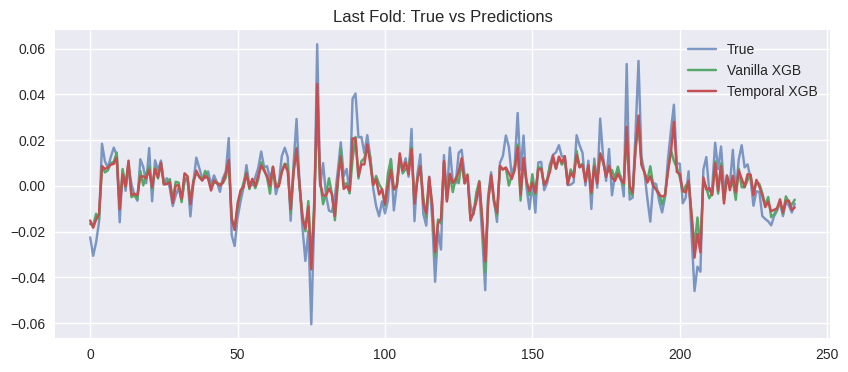

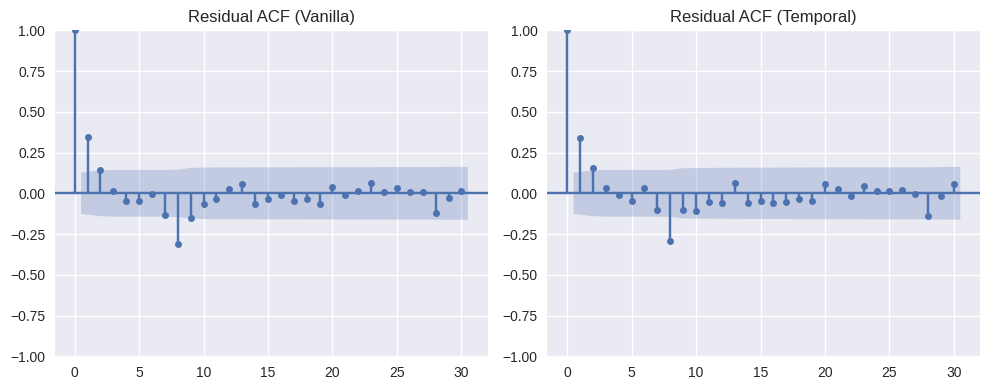

In [ ]:
# ============================================================
# Temporal Gradient Boosting vs Vanilla XGBoost
# Author: [Your Name]
# ============================================================
# Install dependencies
!pip install yfinance xgboost matplotlib pandas numpy scikit-learn tqdm --quiet

import numpy as np, pandas as pd, matplotlib.pyplot as plt, yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tqdm import tqdm
import xgboost as xgb
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('seaborn-v0_8')

# ------------------------------------------------------------
# 1️⃣ Download stock data
# ------------------------------------------------------------
tickers = ["AAPL", "MSFT", "GOOG", "AMZN"]
data = yf.download(tickers, start="2018-01-01", end="2025-01-01")["Close"]
# data = yf.download(tickers, start="2018-01-01", end="2025-01-01")["Adj Close"]
data = data.fillna(method='ffill').stack().reset_index()
data.columns = ["Date", "Ticker", "Close"]
data['Return'] = data.groupby("Ticker")['Close'].pct_change()
data = data.dropna().reset_index(drop=True)

# ------------------------------------------------------------
# 2️⃣ Feature Engineering (lags, rolling stats, etc.)
# ------------------------------------------------------------
def make_features(df, max_lag=5):
    out = df.copy()
    for lag in range(1, max_lag+1):
        out[f"lag_{lag}"] = out.groupby("Ticker")["Return"].shift(lag)
    out["roll_mean_5"] = out.groupby("Ticker")["Return"].transform(lambda x: x.rolling(5).mean())
    out["roll_std_5"] = out.groupby("Ticker")["Return"].transform(lambda x: x.rolling(5).std())
    out = out.dropna().reset_index(drop=True)
    return out

data = make_features(data, max_lag=5)
y = data["Return"].values
X = data.drop(columns=["Return", "Date", "Close"]).set_index("Ticker")

# ------------------------------------------------------------
# 3️⃣ Train/test split by time (walk-forward CV)
# ------------------------------------------------------------
def time_series_cv(df, n_splits=5, horizon=30):
    folds = []
    dates = sorted(df["Date"].unique())
    step = (len(dates) - horizon) // n_splits
    for i in range(n_splits):
        split_point = step*(i+1)
        train_dates = dates[:split_point]
        test_dates = dates[split_point:split_point+horizon]
        train_idx = df[df["Date"].isin(train_dates)].index.values
        test_idx  = df[df["Date"].isin(test_dates)].index.values
        folds.append((train_idx, test_idx))
    return folds

folds = time_series_cv(data, n_splits=5, horizon=60)

# ------------------------------------------------------------
# 4️⃣ Build helper functions for AR coefficients, lag index, volatility weights
# ------------------------------------------------------------
def build_lag_idx(df, series_col='Ticker', max_k=3):
    df2 = df.reset_index(drop=True)
    n = len(df2)
    lag_idx = np.full((n, max_k), -1, dtype=int)
    grouped = df2.groupby(series_col).apply(lambda g: g.index.values)
    for s, positions in grouped.items():
        for pos_idx, global_idx in enumerate(positions):
            for lag in range(1, max_k+1):
                src = pos_idx - lag
                if src >= 0:
                    lag_idx[global_idx, lag-1] = positions[src]
    return lag_idx

def estimate_ar(df, y_col='Return', series_col='Ticker', k=3):
    ar_map = {}
    for s, g in df.groupby(series_col):
        y = g[y_col].values
        if len(y) <= k+5: continue
        Y = y[k:]
        X = np.column_stack([y[k - i - 1: len(y) - i - 1] for i in range(k)])
        coeffs, *_ = np.linalg.lstsq(X, Y, rcond=None)
        ar_map[s] = coeffs
    return ar_map

def per_sample_ar(df, ar_map, k):
    mat = np.zeros((len(df), k))
    for i, s in enumerate(df["Ticker"]):
        mat[i, :] = ar_map.get(s, np.zeros(k))
    return mat

def vol_weights(df, y_col='Return', series_col='Ticker', window=10):
    w = np.ones(len(df))
    for s, g in df.groupby(series_col):
        vol = g[y_col].rolling(window).std().fillna(method='bfill').values
        inv = 1 / (1 + vol)
        w[g.index.values] = inv / inv.mean()
    return w

MAX_K = 3
lag_idx = build_lag_idx(data, max_k=MAX_K)
ar_map = estimate_ar(data, k=MAX_K)
ar_coeffs = per_sample_ar(data, ar_map, MAX_K)
weights = vol_weights(data)

# ------------------------------------------------------------
# 5️⃣ Temporal Objective Function
# ------------------------------------------------------------
def make_temporal_obj(lag_idx, ar_coeffs, lam, weights):
    n, k = lag_idx.shape
    def obj(preds, dtrain):
        y_true = dtrain.get_label()
        preds = preds.astype(float)
        ar_pred = np.zeros_like(preds)
        for i in range(k):
            idx = lag_idx[:, i]
            valid = idx >= 0
            if valid.any():
                ar_pred[valid] += ar_coeffs[valid, i] * preds[idx[valid]]
        temp_resid = preds - ar_pred
        fit_resid = preds - y_true
        grad = 2 * weights * (fit_resid + lam * temp_resid)
        hess = 2 * weights * (1 + lam)
        return grad, hess
    return obj

# ------------------------------------------------------------
# 6️⃣ Cross-validation loop: Vanilla vs Temporal
# ------------------------------------------------------------
params = {"eta":0.1, "max_depth":4, "verbosity":0, "seed":42}
lam = 0.05
rmse_vanilla, rmse_temporal = [], []
mape_vanilla, mape_temporal = [], []

for fold, (tr, te) in enumerate(tqdm(folds)):
    dtrain = xgb.DMatrix(X.iloc[tr], label=y[tr], weight=weights[tr])
    dtest  = xgb.DMatrix(X.iloc[te], label=y[te], weight=weights[te])

    # --- Vanilla ---
    bst_v = xgb.train({**params, "objective":"reg:squarederror"}, dtrain, num_boost_round=100, verbose_eval=False)
    pv = bst_v.predict(dtest)
    rmse_vanilla.append(np.sqrt(mean_squared_error(y[te], pv)))
    mape_vanilla.append(mean_absolute_percentage_error(y[te], pv))

    # --- Temporal ---
    obj = make_temporal_obj(lag_idx, ar_coeffs, lam, weights)
    dall = xgb.DMatrix(X, label=y, weight=weights)
    bst_t = xgb.train(params, dall, num_boost_round=100, obj=obj, verbose_eval=False)
    pt = bst_t.predict(dtest)
    rmse_temporal.append(np.sqrt(mean_squared_error(y[te], pt)))
    mape_temporal.append(mean_absolute_percentage_error(y[te], pt))

# ------------------------------------------------------------
# 7️⃣ Results
# ------------------------------------------------------------
results = pd.DataFrame({
    "Fold": np.arange(1, len(folds)+1),
    "Vanilla_RMSE": rmse_vanilla,
    "Temporal_RMSE": rmse_temporal,
    "Vanilla_MAPE": mape_vanilla,
    "Temporal_MAPE": mape_temporal
})
results["Δ_RMSE"] = results["Temporal_RMSE"] - results["Vanilla_RMSE"]
results["Δ_MAPE"] = results["Temporal_MAPE"] - results["Vanilla_MAPE"]
print("\n=== Cross-Validation Results ===\n")
print(results.round(6))
print("\nMean RMSE Improvement:", results["Δ_RMSE"].mean())
print("Mean MAPE Improvement:", results["Δ_MAPE"].mean())

# ------------------------------------------------------------
# 8️⃣ Diagnostic plot for last fold
# ------------------------------------------------------------
plt.figure(figsize=(10,4))
plt.plot(y[te], label="True", alpha=0.7)
plt.plot(pv, label="Vanilla XGB")
plt.plot(pt, label="Temporal XGB")
plt.legend()
plt.title("Last Fold: True vs Predictions")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10,4))
plot_acf(y[te]-pv, ax=ax[0], lags=30, title="Residual ACF (Vanilla)")
plot_acf(y[te]-pt, ax=ax[1], lags=30, title="Residual ACF (Temporal)")
plt.tight_layout()
plt.show()


/tmp/ipython-input-522704235.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df2.groupby(series_col).apply(lambda g: g.index.values)
/tmp/ipython-input-522704235.py:96: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vol = g[y_col].rolling(window).std().fillna(method='bfill').values
Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


   fold  rmse_vanilla  rmse_single_temporal  rmse_multi_scale  \
0     1      0.010023              0.010208          0.012760   
1     2      0.011401              0.011960          0.015559   
2     3      0.012653              0.012406          0.016881   
3     4      0.007026              0.007958          0.011275   
4     5      0.007417              0.007624          0.010307   

   delta_single_vs_vanilla  delta_multi_vs_vanilla  
0                 0.000185                0.002737  
1                 0.000559                0.004158  
2                -0.000247                0.004228  
3                 0.000931                0.004248  
4                 0.000207                0.002890  

Mean deltas:
Single temporal - vanilla: 0.0003268579467814359
Multi-scale ensemble - vanilla: 0.0036521795790298043


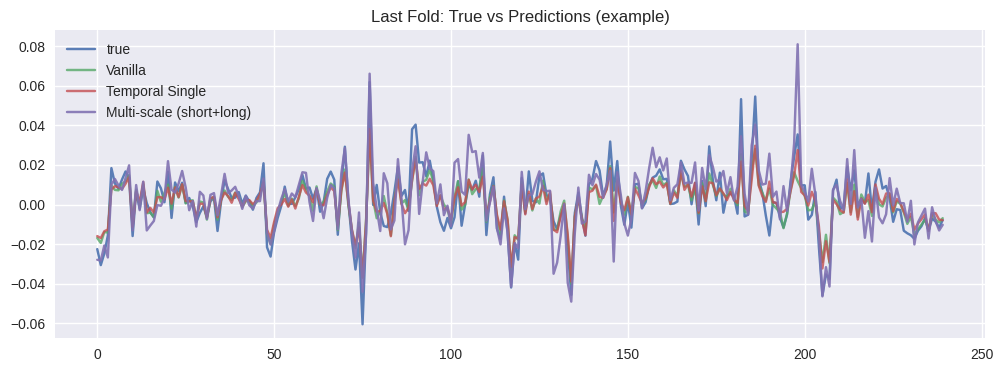

In [ ]:
# ===========================
# Multi-scale Temporal XGBoost Ensemble
# ===========================
# Assumes you already have:
# - data (DataFrame with columns Date, Ticker, Return, lag_*, roll_mean_5, roll_std_5, ...)
# - X (features), y (targets)
# - helper functions: build_lag_idx, estimate_ar, per_sample_ar, vol_weights, make_temporal_obj
# - folds (list of (train_idx, test_idx))
#
# This cell trains:
#  - vanilla XGBoost (baseline)
#  - temporal single XGBoost (one model)
#  - temporal multi-scale ensemble: temporal_short + temporal_long (additive)
#
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------- Configuration: define short & long scales -------
short_cfg = {
    "max_k": 2,            # AR order for short model
    "lags_features": [1,2],# lag columns to include for short model
    "lambda": 0.02,
    "params": {"eta":0.1, "max_depth":4, "verbosity":0, "seed":42, "objective":"reg:squarederror"},
    "rounds": 100
}
long_cfg = {
    "max_k": 6,            # AR order for long model
    "lags_features": [1,2,3,4,5,6],
    "lambda": 0.05,
    "params": {"eta":0.05, "max_depth":5, "verbosity":0, "seed":42, "objective":"reg:squarederror"},
    "rounds": 150
}
# Baseline params
vanilla_params = {"eta":0.1, "max_depth":4, "verbosity":0, "seed":42, "objective":"reg:squarederror"}
vanilla_rounds = 120

# ------- Helper to build feature matrix for a given scale -------
def build_scale_X(df, lags_features):
    # lags_features is list of integers corresponding to lag_N columns existing in df (e.g., lag_1, lag_2...)
    cols = []
    cols.append("roll_mean_5")
    cols.append("roll_std_5")
    for lag in lags_features:
        cols.append(f"lag_{lag}")
    # add exogenous if exists
    if "exog" in df.columns:
        cols.append("exog")
    # ensure cols exist
    cols = [c for c in cols if c in df.columns]
    Xs = df[cols].values
    return Xs, cols

# ------- Build lag indices and global volatility weights (reuse) -------
# Build global lag_idx up to the maximum of the two ks
max_global_k = max(short_cfg["max_k"], long_cfg["max_k"])
lag_idx_global = build_lag_idx(data, max_k=max_global_k)   # data is the DataFrame from earlier
vol_w = vol_weights(data)

# ------- Estimate AR coefficients per scale (per-series maps) -------
ar_map_short = estimate_ar(data.rename(columns={"Return":"Return"}), k=short_cfg["max_k"])
ar_map_long  = estimate_ar(data.rename(columns={"Return":"Return"}), k=long_cfg["max_k"])

# map per-sample ar matrices (we'll pad if necessary to global k)
def per_sample_ar_mat_for_k(df, ar_map, k, max_global_k):
    # returns (n_samples, max_global_k) where columns beyond k are zero
    n = len(df)
    mat = np.zeros((n, max_global_k))
    for i,s in enumerate(df["Ticker"]):
        vec = ar_map.get(s, np.zeros(k))
        mat[i, :k] = vec
    return mat

ar_mat_short = per_sample_ar_mat_for_k(data, ar_map_short, short_cfg["max_k"], max_global_k)
ar_mat_long  = per_sample_ar_mat_for_k(data, ar_map_long, long_cfg["max_k"], max_global_k)

# -------- CV loop: compute metrics per model per fold --------
fold_results = []
for fold, (tr_idx, te_idx) in enumerate(tqdm(folds, desc="Folds")):
    # Build X matrices for short, long and vanilla
    X_short_vals, cols_short = build_scale_X(data, short_cfg["lags_features"])
    X_long_vals,  cols_long  = build_scale_X(data, long_cfg["lags_features"])
    X_vanilla_vals = X.reset_index(drop=True).values # original full features built earlier

    # Train vanilla on train rows
    dtrain_v = xgb.DMatrix(X_vanilla_vals[tr_idx], label=y[tr_idx], weight=vol_w[tr_idx])
    dtest_v  = xgb.DMatrix(X_vanilla_vals[te_idx], label=y[te_idx], weight=vol_w[te_idx])
    bst_v = xgb.train(vanilla_params, dtrain_v, num_boost_round=vanilla_rounds, verbose_eval=False)
    pred_v = bst_v.predict(dtest_v)
    rmse_v = np.sqrt(mean_squared_error(y[te_idx], pred_v))

    # --- Single temporal model (pooled k = max_global_k) ---
    # For the temporal single we reuse the global lag_idx and ar_mat_long (or pooled)
    # Use pooled lambda as average of short & long for single temporal baseline
    lam_single = 0.04
    lambda_full_single = np.ones(len(data)) * lam_single
    # create DMatrix with full rows but zero-weight outside train
    full_weights = np.zeros(len(data)); full_weights[tr_idx] = vol_w[tr_idx]
    dall = xgb.DMatrix(X_vanilla_vals, label=y, weight=full_weights)
    obj_single = make_temporal_obj(lag_idx_global, ar_mat_long, lambda_full_single, weights=full_weights)
    bst_single = xgb.train({"eta":0.07, "max_depth":5, "verbosity":0, "seed":42}, dall, num_boost_round=120, obj=obj_single, verbose_eval=False)
    pred_single = bst_single.predict(xgb.DMatrix(X_vanilla_vals[te_idx]))
    rmse_single = np.sqrt(mean_squared_error(y[te_idx], pred_single))

    # --- Multi-scale ensemble: train short model and long model separately with their own objectives ---
    # Prepare DMatrix for short model
    full_weights_short = np.zeros(len(data)); full_weights_short[tr_idx] = vol_w[tr_idx]
    dall_short = xgb.DMatrix(X_short_vals, label=y, weight=full_weights_short)
    lambda_full_short = np.ones(len(data)) * short_cfg["lambda"]
    obj_short = make_temporal_obj(lag_idx_global, ar_mat_short, lambda_full_short, weights=full_weights_short)
    bst_short = xgb.train(short_cfg["params"], dall_short, num_boost_round=short_cfg["rounds"], obj=obj_short, verbose_eval=False)

    # Prepare DMatrix for long model
    full_weights_long = np.zeros(len(data)); full_weights_long[tr_idx] = vol_w[tr_idx]
    dall_long = xgb.DMatrix(X_long_vals, label=y, weight=full_weights_long)
    lambda_full_long = np.ones(len(data)) * long_cfg["lambda"]
    obj_long = make_temporal_obj(lag_idx_global, ar_mat_long, lambda_full_long, weights=full_weights_long)
    bst_long = xgb.train(long_cfg["params"], dall_long, num_boost_round=long_cfg["rounds"], obj=obj_long, verbose_eval=False)

    # Predictions on test set (additive)
    pred_short = bst_short.predict(xgb.DMatrix(X_short_vals[te_idx]))
    pred_long  = bst_long.predict(xgb.DMatrix(X_long_vals[te_idx]))
    pred_ensemble = pred_short + pred_long
    rmse_ens = np.sqrt(mean_squared_error(y[te_idx], pred_ensemble))

    fold_results.append({
        "fold": fold+1,
        "rmse_vanilla": rmse_v,
        "rmse_single_temporal": rmse_single,
        "rmse_multi_scale": rmse_ens
    })

# Summarize results
import pandas as pd
df_res = pd.DataFrame(fold_results)
df_res["delta_single_vs_vanilla"] = df_res["rmse_single_temporal"] - df_res["rmse_vanilla"]
df_res["delta_multi_vs_vanilla"] = df_res["rmse_multi_scale"] - df_res["rmse_vanilla"]
print(df_res.round(6))
print("\nMean deltas:")
print("Single temporal - vanilla:", df_res["delta_single_vs_vanilla"].mean())
print("Multi-scale ensemble - vanilla:", df_res["delta_multi_vs_vanilla"].mean())

# Plot example: last fold true vs preds
last = folds[-1][1]  # last fold test indices
plt.figure(figsize=(12,4))
plt.plot(y[last], label="true", alpha=0.9)
# compute preds for last fold for each approach (already computed in last loop; recalc quickly)
pred_v_all = bst_v.predict(xgb.DMatrix(X_vanilla_vals[last]))
pred_single_all = bst_single.predict(xgb.DMatrix(X_vanilla_vals[last]))
pred_short_all = bst_short.predict(xgb.DMatrix(X_short_vals[last]))
pred_long_all = bst_long.predict(xgb.DMatrix(X_long_vals[last]))
plt.plot(pred_v_all, label="Vanilla", alpha=0.8)
plt.plot(pred_single_all, label="Temporal Single", alpha=0.8)
plt.plot(pred_short_all + pred_long_all, label="Multi-scale (short+long)", alpha=0.9)
plt.legend(); plt.title("Last Fold: True vs Predictions (example)"); plt.show()

/tmp/ipython-input-522704235.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df2.groupby(series_col).apply(lambda g: g.index.values)
/tmp/ipython-input-522704235.py:96: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vol = g[y_col].rolling(window).std().fillna(method='bfill').values
Residual-stacked folds: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


=== Residual-Stacked Multi-Scale Temporal XGBoost ===
   fold  RMSE_Vanilla  RMSE_SingleTemporal  RMSE_MultiScale_ResidualStack  \
0     1      0.010023             0.010386                       0.012714   
1     2      0.011401             0.011859                       0.017284   
2     3      0.012653             0.013212                       0.016480   
3     4      0.007026             0.007828                       0.011909   
4     5      0.007417             0.007872                       0.011278   

   Δ_Single_vs_Vanilla  Δ_MultiStack_vs_Vanilla  
0             0.000363                 0.002691  
1             0.000458                 0.005883  
2             0.000559                 0.003827  
3             0.000802                 0.004883  
4             0.000455                 0.003861  

Mean improvements:
Δ_Single_vs_Vanilla: 0.000527187701727177
Δ_MultiStack_vs_Vanilla: 0.004228943516608871


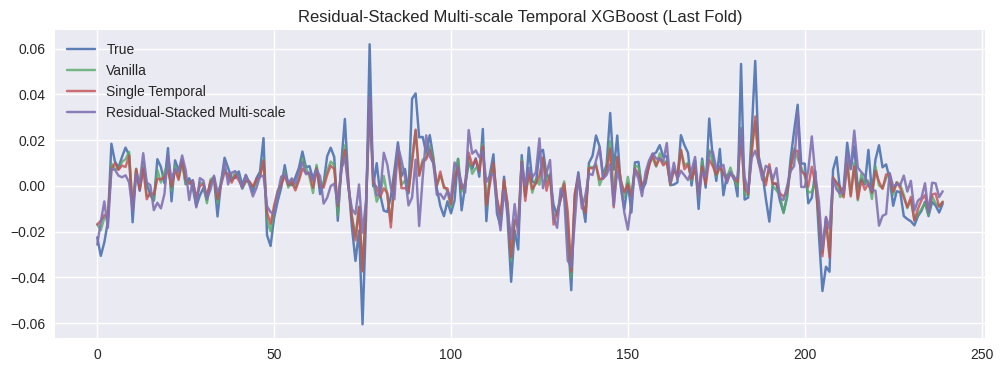

In [ ]:
# ==============================================
# Multi-scale (Residual-Stacked) Temporal XGBoost
# ==============================================
import numpy as np, pandas as pd, xgboost as xgb
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
short_cfg = {
    "max_k": 3,
    "lags_features": [1, 2, 3],
    "lambda": 0.02,
    "params": {"eta": 0.1, "max_depth": 4, "verbosity": 0, "seed": 42},
    "rounds": 120,
}
long_cfg = {
    "max_k": 8,
    "lags_features": [5, 10, 15, 20],
    "lambda": 1,
    "params": {"eta": 0.05, "max_depth": 5, "verbosity": 0, "seed": 42},
    "rounds": 180,
}
vanilla_params = {"eta": 0.1, "max_depth": 4, "verbosity": 0, "seed": 42}
vanilla_rounds = 120

# --- BUILD FEATURE MATRICES FOR EACH SCALE ---
def build_scale_X(df, lags_features):
    cols = [f"lag_{l}" for l in lags_features if f"lag_{l}" in df.columns]
    if "roll_mean_5" in df.columns: cols.append("roll_mean_5")
    if "roll_std_5" in df.columns: cols.append("roll_std_5")
    if "exog" in df.columns: cols.append("exog")
    return df[cols].values, cols

max_global_k = max(short_cfg["max_k"], long_cfg["max_k"])
lag_idx_global = build_lag_idx(data, max_k=max_global_k)
vol_w = vol_weights(data)

ar_map_short = estimate_ar(data.rename(columns={"Return":"Return"}), k=short_cfg["max_k"])
ar_map_long  = estimate_ar(data.rename(columns={"Return":"Return"}), k=long_cfg["max_k"])

def per_sample_ar_mat_for_k(df, ar_map, k, max_global_k):
    n = len(df)
    mat = np.zeros((n, max_global_k))
    for i, s in enumerate(df["Ticker"]):
        vec = ar_map.get(s, np.zeros(k))
        mat[i, :k] = vec
    return mat

ar_mat_short = per_sample_ar_mat_for_k(data, ar_map_short, short_cfg["max_k"], max_global_k)
ar_mat_long  = per_sample_ar_mat_for_k(data, ar_map_long, long_cfg["max_k"], max_global_k)

# --- CROSS VALIDATION LOOP ---
results = []
X_reset = X.reset_index(drop=True) # Reset index of X here
for fold, (tr_idx, te_idx) in enumerate(tqdm(folds, desc="Residual-stacked folds")):
    # --- Baseline XGBoost ---
    dtrain_v = xgb.DMatrix(X_reset.iloc[tr_idx], label=y[tr_idx], weight=vol_w[tr_idx])
    dtest_v  = xgb.DMatrix(X_reset.iloc[te_idx],  label=y[te_idx])
    bst_v = xgb.train(vanilla_params, dtrain_v, num_boost_round=vanilla_rounds, verbose_eval=False)
    pred_v = bst_v.predict(dtest_v)
    rmse_v = np.sqrt(mean_squared_error(y[te_idx], pred_v))

    # --- Single Temporal XGBoost ---
    full_w = np.zeros(len(y)); full_w[tr_idx] = vol_w[tr_idx]
    dall_single = xgb.DMatrix(X_reset, label=y, weight=full_w)
    lam_vec = np.ones(len(y)) * 0.04
    obj_single = make_temporal_obj(lag_idx_global, ar_mat_long, lam_vec, weights=full_w)
    bst_single = xgb.train({"eta":0.07, "max_depth":5, "verbosity":0, "seed":42},
                           dall_single, num_boost_round=120, obj=obj_single, verbose_eval=False)
    pred_single = bst_single.predict(xgb.DMatrix(X_reset.iloc[te_idx]))
    rmse_single = np.sqrt(mean_squared_error(y[te_idx], pred_single))

    # --- MULTI-SCALE RESIDUAL-STACKED ---
    X_short, _ = build_scale_X(data, short_cfg["lags_features"])
    X_long,  _ = build_scale_X(data, long_cfg["lags_features"])

    # short-term model (temporal)
    full_w_short = np.zeros(len(y)); full_w_short[tr_idx] = vol_w[tr_idx]
    dall_short = xgb.DMatrix(X_short, label=y, weight=full_w_short)
    lam_short = np.ones(len(y)) * short_cfg["lambda"]
    obj_short = make_temporal_obj(lag_idx_global, ar_mat_short, lam_short, weights=full_w_short)
    bst_short = xgb.train(short_cfg["params"], dall_short, num_boost_round=short_cfg["rounds"], obj=obj_short, verbose_eval=False)

    # residuals on train
    pred_short_train = bst_short.predict(xgb.DMatrix(X_short[tr_idx]))
    resid_train = y[tr_idx] - pred_short_train

    # long-term model (temporal) trained on residuals
    full_w_long = np.zeros(len(y)); full_w_long[tr_idx] = vol_w[tr_idx]
    dall_long = xgb.DMatrix(X_long, label=np.concatenate([resid_train, np.zeros(len(y)-len(resid_train))]), weight=full_w_long)
    lam_long = np.ones(len(y)) * long_cfg["lambda"]
    obj_long = make_temporal_obj(lag_idx_global, ar_mat_long, lam_long, weights=full_w_long)
    bst_long = xgb.train(long_cfg["params"], dall_long, num_boost_round=long_cfg["rounds"], obj=obj_long, verbose_eval=False)

    # predictions
    pred_short_test = bst_short.predict(xgb.DMatrix(X_short[te_idx]))
    pred_long_test  = bst_long.predict(xgb.DMatrix(X_long[te_idx]))
    pred_stack = pred_short_test + pred_long_test
    rmse_stack = np.sqrt(mean_squared_error(y[te_idx], pred_stack))

    results.append({
        "fold": fold + 1,
        "RMSE_Vanilla": rmse_v,
        "RMSE_SingleTemporal": rmse_single,
        "RMSE_MultiScale_ResidualStack": rmse_stack
    })

# --- RESULTS ---
res_df = pd.DataFrame(results)
res_df["Δ_Single_vs_Vanilla"] = res_df["RMSE_SingleTemporal"] - res_df["RMSE_Vanilla"]
res_df["Δ_MultiStack_vs_Vanilla"] = res_df["RMSE_MultiScale_ResidualStack"] - res_df["RMSE_Vanilla"]

print("=== Residual-Stacked Multi-Scale Temporal XGBoost ===")
print(res_df.round(6))
print("\nMean improvements:")
print("Δ_Single_vs_Vanilla:", res_df["Δ_Single_vs_Vanilla"].mean())
print("Δ_MultiStack_vs_Vanilla:", res_df["Δ_MultiStack_vs_Vanilla"].mean())

# --- PLOT last fold example ---
last = folds[-1][1]
plt.figure(figsize=(12,4))
plt.plot(y[last], label="True", alpha=0.9)
# compute preds for last fold for each approach (already computed in last loop; recalc quickly)
pred_v_all = bst_v.predict(xgb.DMatrix(X_reset.iloc[last]))
pred_single_all = bst_single.predict(xgb.DMatrix(X_reset.iloc[last]))
pred_short_all = bst_short.predict(xgb.DMatrix(X_short[last]))
pred_long_all = bst_long.predict(xgb.DMatrix(X_long[last]))
plt.plot(pred_v_all, label="Vanilla", alpha=0.8)
plt.plot(pred_single_all, label="Single Temporal", alpha=0.8)
plt.plot(pred_short_all + pred_long_all, label="Residual-Stacked Multi-scale", alpha=0.9)
plt.title("Residual-Stacked Multi-scale Temporal XGBoost (Last Fold)")
plt.legend(); plt.show()

In [ ]:
# Adjusted lambda (weaken long model regularization)
long_cfg["lambda"] = 0.005

# Normalize residuals before training long model
resid_train = (resid_train - resid_train.mean()) / (resid_train.std() + 1e-6)

# Optional: use weighting to de-emphasize low-volatility regions
weights = vol_w[tr_idx] / np.max(vol_w[tr_idx])
dall_long = xgb.DMatrix(X_long[tr_idx], label=resid_train, weight=weights)


/tmp/ipython-input-4090340967.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("GC=F", start="2010-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


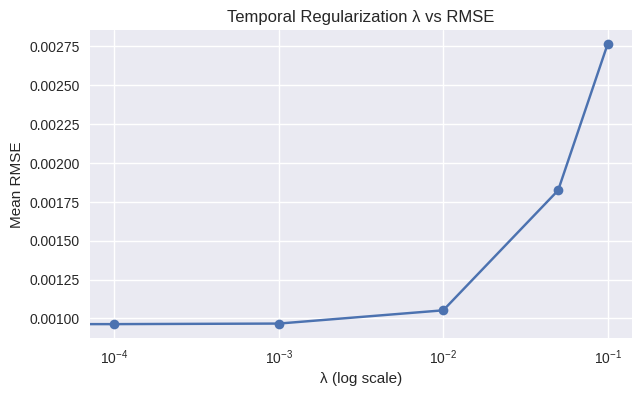

=== Temporal XGBoost λ Tuning Results ===
   lambda      RMSE        MAPE
0  0.0000  0.000978   51.560156
1  0.0001  0.000963   52.029227
2  0.0010  0.000967   82.800228
3  0.0100  0.001052   69.840311
4  0.0500  0.001824  161.572166
5  0.1000  0.002765  273.206670

✅ Best λ = 0.00010  |  RMSE = 0.000963  |  MAPE = 52.029227


In [ ]:
# ===============================================================
# 📈 Improved Single-Temporal XGBoost for Financial Time Series
# ===============================================================
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# 1️⃣  Load and prepare stock data (you can replace with any series)
# ---------------------------------------------------------------
# Example: AAPL stock (use your own data)
!pip install yfinance --quiet
import yfinance as yf

# data = yf.download("AAPL", start="2015-01-01", end="2023-01-01")
data = yf.download("GC=F", start="2010-01-01", end="2023-01-01")
data["ret"] = data["Close"].pct_change()
data["target"] = data["ret"].shift(-1)  # predict next-day return

# ---------------------------------------------------------------
# 2️⃣  Create lag & rolling features
# ---------------------------------------------------------------
for lag in [1, 2, 3, 5, 10]:
    data[f"lag_{lag}"] = data["ret"].shift(lag)

for win in [3, 5, 10, 20]:
    data[f"ma_{win}"] = data["ret"].rolling(win).mean().shift(1)
    data[f"vol_{win}"] = data["ret"].rolling(win).std().shift(1)

data.dropna(inplace=True)

# ---------------------------------------------------------------
# 3️⃣  Define features and target
# ---------------------------------------------------------------
features = [c for c in data.columns if c not in ["target", "Close", "Adj Close", "Open", "High", "Low", "Volume"]]
X = data[features]
y = data["target"]

# ---------------------------------------------------------------
# 4️⃣  Normalize inputs
# ---------------------------------------------------------------
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# ---------------------------------------------------------------
# 5️⃣  Temporal objective function
# ---------------------------------------------------------------
def make_temporal_obj(lag_idx, lam=0.01):
    """Add autocorrelation-aware regularization to XGBoost loss."""
    def obj(preds, dtrain):
        y = dtrain.get_label()
        grad = preds - y
        hess = np.ones_like(y)
        for l in lag_idx:
            lag_pred = np.roll(preds, l)
            lag_pred[:l] = preds[:l]  # prevent leakage
            grad += lam * (preds - lag_pred)
        return grad, hess
    return obj

# ---------------------------------------------------------------
# 6️⃣  Cross-validation + λ tuning
# ---------------------------------------------------------------
tscv = TimeSeriesSplit(n_splits=5)
lag_idx = [1, 2, 3]

lambda_grid = [0.0, 1e-4, 1e-3, 1e-2, 5e-2, 0.1]
results = []

for lam in lambda_grid:
    rmses, mapes = [], []
    for fold, (tr_idx, te_idx) in enumerate(tscv.split(X_scaled), 1):
        X_tr, X_te = X_scaled.iloc[tr_idx], X_scaled.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dtest = xgb.DMatrix(X_te, label=y_te)

        params = {"max_depth": 4, "eta": 0.05, "subsample": 0.8, "colsample_bytree": 0.8, "verbosity": 0}
        bst = xgb.train(params, dtrain, num_boost_round=300,
                        obj=make_temporal_obj(lag_idx, lam),
                        verbose_eval=False)

        preds = bst.predict(dtest)
        rmse = np.sqrt(mean_squared_error(y_te, preds))
        # Handle zero values in y_te for MAPE calculation
        mape = mean_absolute_percentage_error(y_te + 1e-8, preds + 1e-8)

        rmses.append(rmse)
        mapes.append(mape)

    results.append({"lambda": lam, "RMSE": np.mean(rmses), "MAPE": np.mean(mapes)})

# ---------------------------------------------------------------
# 7️⃣  Plot results and show best λ
# ---------------------------------------------------------------
results_df = pd.DataFrame(results)
best_row = results_df.loc[results_df["RMSE"].idxmin()]

plt.figure(figsize=(7,4))
plt.plot(results_df["lambda"], results_df["RMSE"], marker='o')
plt.xscale("log")
plt.title("Temporal Regularization λ vs RMSE")
plt.xlabel("λ (log scale)")
plt.ylabel("Mean RMSE")
plt.grid(True)
plt.show()

print("=== Temporal XGBoost λ Tuning Results ===")
print(results_df)
print(f"\n✅ Best λ = {best_row['lambda']:.5f}  |  RMSE = {best_row['RMSE']:.6f}  |  MAPE = {best_row['MAPE']:.6f}")


Commodity: Gold GC=F
Downloading...
Tuning lambda (vol-weighted CV)...
Best λ: 0.0
   lambda  RMSE_mean
0  0.0000   0.006004
1  0.0001   0.006004
2  0.0010   0.006020
3  0.0100   0.006041
4  0.0500   0.006145
Final temporal model RMSE on holdout fold: 0.005858
Training residual-stacked short/long models for decomposition...
Residual-stacked short+long RMSE on holdout: 0.010040


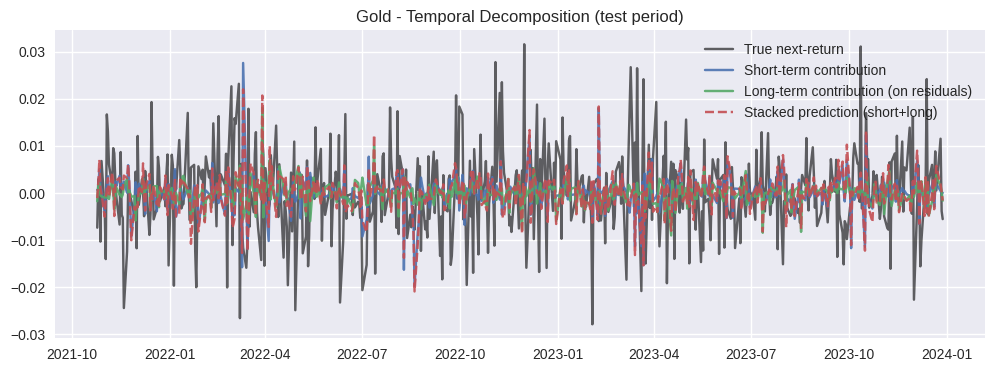


Commodity: CrudeOil CL=F
Downloading...
Tuning lambda (vol-weighted CV)...
Best λ: 0.001
   lambda  RMSE_mean
0  0.0000   0.015008
1  0.0001   0.015009
2  0.0010   0.014874
3  0.0100   0.015231
4  0.0500   0.015625
Final temporal model RMSE on holdout fold: 0.014267
Training residual-stacked short/long models for decomposition...
Residual-stacked short+long RMSE on holdout: 0.029324


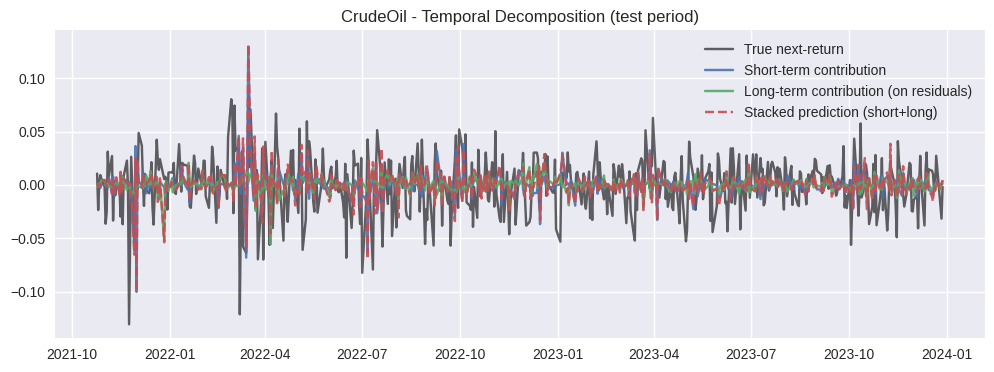


Commodity: NaturalGas NG=F
Downloading...
Tuning lambda (vol-weighted CV)...
Best λ: 0.001
   lambda  RMSE_mean
0  0.0000   0.020296
1  0.0001   0.020400
2  0.0010   0.020225
3  0.0100   0.020349
4  0.0500   0.020651
Final temporal model RMSE on holdout fold: 0.019629
Training residual-stacked short/long models for decomposition...
Residual-stacked short+long RMSE on holdout: 0.060580


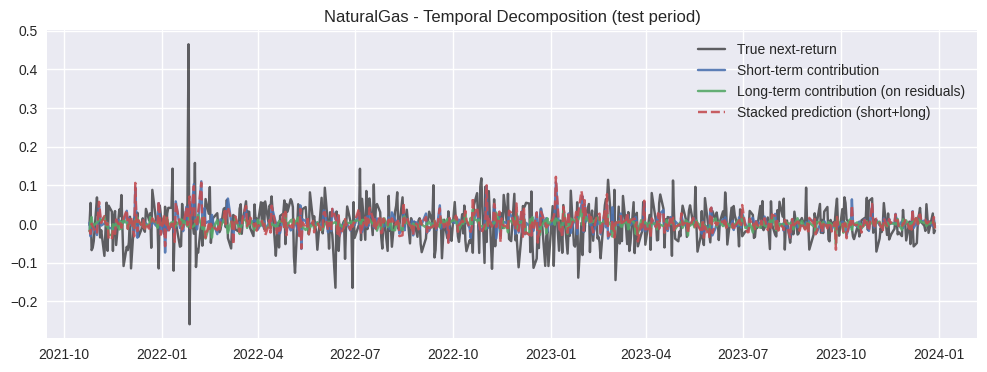


Commodity: Silver SI=F
Downloading...
Tuning lambda (vol-weighted CV)...
Best λ: 0.01
   lambda  RMSE_mean
0  0.0000   0.010508
1  0.0001   0.010597
2  0.0010   0.010592
3  0.0100   0.010494
4  0.0500   0.010826
Final temporal model RMSE on holdout fold: 0.010214
Training residual-stacked short/long models for decomposition...
Residual-stacked short+long RMSE on holdout: 0.019980


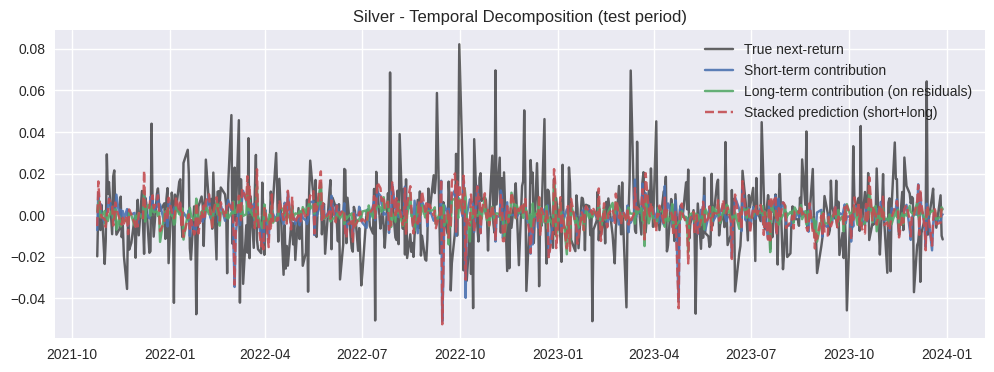


Commodity: Copper HG=F
Downloading...
Tuning lambda (vol-weighted CV)...
Best λ: 0.001
   lambda  RMSE_mean
0  0.0000   0.008640
1  0.0001   0.008641
2  0.0010   0.008585
3  0.0100   0.008685
4  0.0500   0.008856
Final temporal model RMSE on holdout fold: 0.008075
Training residual-stacked short/long models for decomposition...
Residual-stacked short+long RMSE on holdout: 0.016080


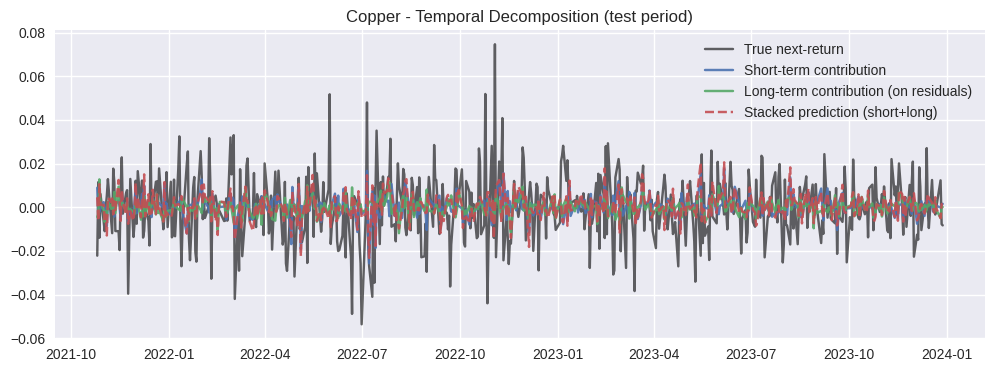


=== Summary (per commodity) ===

Gold: best_lambda=0.00000, rmse_temporal=0.005858, rmse_stack=0.010040

CrudeOil: best_lambda=0.00100, rmse_temporal=0.014267, rmse_stack=0.029324

NaturalGas: best_lambda=0.00100, rmse_temporal=0.019629, rmse_stack=0.060580

Silver: best_lambda=0.01000, rmse_temporal=0.010214, rmse_stack=0.019980

Copper: best_lambda=0.00100, rmse_temporal=0.008075, rmse_stack=0.016080


In [36]:
# ===============================================================
# Temporal XGBoost on Commodities
# - adds volatility-weighted loss (heteroskedastic weights)
# - computes SHAP feature importances
# - trains residual-stacked multi-scale (short + long) and plots decomposition
# ===============================================================
# !pip install yfinance shap xgboost --quiet

import numpy as np
import pandas as pd
import yfinance as yf
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
# import shap # Remove shap import
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")

# -----------------------------
# CONFIG
# -----------------------------
tickers = {
    "Gold": "GC=F",
    "CrudeOil": "CL=F",
    "NaturalGas": "NG=F",
    "Silver": "SI=F",
    "Copper": "HG=F"
}
# CV / model settings
n_splits = 4
lag_idx = [1, 2, 3]
lambda_grid = [0.0, 1e-4, 1e-3, 1e-2, 5e-2]
num_boost_round_cv = 200
num_boost_round_final = 300

# short/long scale config for decomposition
short_cfg = {"lags": [1,2,3], "rounds": 150, "params": {"eta":0.1,"max_depth":4,"verbosity":0}}
long_cfg  = {"lags": [5,10,15,20], "rounds": 200, "params": {"eta":0.05,"max_depth":5,"verbosity":0}}

# -----------------------------
# helper functions
# -----------------------------
def build_features(df):
    df = df.copy()
    df["ret"] = df["Close"].pct_change()
    for lag in [1,2,3,5,10,15,20]:
        df[f"lag_{lag}"] = df["ret"].shift(lag)
    for win in [3,5,10,20]:
        df[f"ma_{win}"] = df["ret"].rolling(win).mean().shift(1)
        df[f"vol_{win}"] = df["ret"].rolling(win).std().shift(1)
    df.dropna(inplace=True)
    return df

def vol_weights(series_ret, window=20, min_w=0.5, max_w=1.5):
    # normalize weights so mean ~1; higher vol -> lower weight
    vol = series_ret.rolling(window).std().fillna(method='bfill')
    inv = 1.0/(1.0 + vol)
    # scale to [min_w, max_w]
    a = (inv - inv.min())/(inv.max()-inv.min()+1e-9)
    return min_w + a*(max_w-min_w)

def make_temporal_obj(lag_idx_global, ar_coeffs_mat, lambda_per_sample, weight_vec):
    # returns custom obj that honors sample weights (volatility)
    n, k = lag_idx_global.shape
    def obj(preds, dtrain):
        y_true = dtrain.get_label()
        preds = preds.astype(float)
        ar_pred = np.zeros_like(preds)
        for i in range(k):
            idx = lag_idx_global[:, i]
            valid = idx >= 0
            if valid.any():
                ar_pred[valid] += ar_coeffs_mat[valid, i] * preds[idx[valid]]
        temp_resid = preds - ar_pred
        fit_resid = preds - y_true
        lam = lambda_per_sample
        w = weight_vec if weight_vec is not None else np.ones_like(fit_resid)
        grad = 2.0 * w * (fit_resid + lam * temp_resid)
        hess = 2.0 * w * (1.0 + lam)
        return grad, hess
    return obj

def estimate_ar_map(df, y_col="ret", k=3):
    ar_map = {}
    for s, g in df.groupby("Ticker"):
        y = g[y_col].values
        if len(y) <= k+5:
            ar_map[s] = np.zeros(k)
            continue
        Y = y[k:]
        X = np.column_stack([y[k - i - 1: len(y) - i - 1] for i in range(k)])
        coeffs, *_ = np.linalg.lstsq(X, Y, rcond=None)
        ar_map[s] = coeffs
    return ar_map

def per_sample_ar_matrix(df, ar_map, k):
    arr = np.zeros((len(df), k))
    for i,s in enumerate(df["Ticker"]):
        arr[i,:] = ar_map.get(s, np.zeros(k))
    return arr

def build_lag_index_matrix(df, series_col="Ticker", max_k=3):
    df2 = df.reset_index(drop=True)
    n = len(df2)
    lag_idx = np.full((n, max_k), -1, dtype=int)
    grouped = df2.groupby(series_col).apply(lambda g: g.index.values)
    for s, positions in grouped.items():
        for pos_idx, global_idx in enumerate(positions):
            for lag in range(1, max_k+1):
                src_pos = pos_idx - lag
                if src_pos >= 0:
                    lag_idx[global_idx, lag-1] = positions[src_pos]
    return lag_idx

# -----------------------------
# MAIN: loop over commodities
# -----------------------------
summary = {}
for name, symbol in tickers.items():
    print("\n====================================")
    print("Commodity:", name, symbol)
    print("Downloading...")
    df = yf.download(symbol, start="2013-01-01", end="2024-01-01", progress=False)
    if df.shape[0] < 200:
        print("Not enough data, skipping.")
        continue
    df_feat = build_features(df)
    df_feat["Ticker"] = name  # single-ticker dataset but keep Ticker for functions
    # features & target
    # Explicitly select only numerical columns for features
    numerical_features = df_feat.select_dtypes(include=np.number).columns.tolist()
    features = [c for c in numerical_features if c not in ["target"]]

    # use next-day return as target
    df_feat["target"] = df_feat["ret"].shift(-1)
    df_feat.dropna(inplace=True)
    X_full = df_feat[features] # Select only numerical features
    y_full = df_feat["target"].values

    # standardize features
    scaler = StandardScaler()
    Xs = pd.DataFrame(scaler.fit_transform(X_full), columns=X_full.columns, index=X_full.index) # Scale X_full

    # compute per-sample volatility weights (by ticker)
    # Since single ticker, it's simple
    w_series = vol_weights(df_feat["ret"], window=20)
    weight_vec = w_series.values

    # build lag_index and AR map/matrix for temporal objective
    max_k = max(lag_idx)  # here lag_idx is [1,2,3]
    lag_idx_mat = build_lag_index_matrix(df_feat, max_k=max_k)
    ar_map = estimate_ar_map(df_feat, y_col="ret", k=max_k)
    ar_coeffs_mat = per_sample_ar_matrix(df_feat, ar_map, max_k)

    # CV to find best lambda (with volatility weights)
    tscv = TimeSeriesSplit(n_splits=n_splits)
    res_list = []
    print("Tuning lambda (vol-weighted CV)...")
    for lam in lambda_grid:
        rmses = []
        for tr_idx, te_idx in tscv.split(Xs):
            X_tr, X_te = Xs.iloc[tr_idx], Xs.iloc[te_idx]
            y_tr, y_te = y_full[tr_idx], y_full[te_idx]
            # use DMatrix with per-row weights (train rows nonzero; test weights used only for eval)
            dtrain = xgb.DMatrix(X_tr, label=y_tr, weight=weight_vec[tr_idx])
            dtest  = xgb.DMatrix(X_te, label=y_te)
            # build full DMatrix and obj if using custom objective; simpler: pass weights and use custom obj that also accepts weight_vec sized to full
            # For CV we'll train on only training rows with weight provided
            full_w = np.zeros(len(df_feat)); full_w[tr_idx] = weight_vec[tr_idx]
            dall = xgb.DMatrix(Xs, label=y_full, weight=full_w)
            obj = make_temporal_obj(lag_idx_mat, ar_coeffs_mat, np.ones(len(df_feat))*lam, weight_vec)
            bst = xgb.train({"eta":0.1, "max_depth":4, "verbosity":0}, dall, num_boost_round=num_boost_round_cv, obj=obj, verbose_eval=False)
            # predict on te
            preds = bst.predict(xgb.DMatrix(Xs.iloc[te_idx]))
            rmse = np.sqrt(mean_squared_error(y_te, preds))
            rmses.append(rmse)
        res_list.append({"lambda": lam, "RMSE_mean": np.mean(rmses)})
    res_df = pd.DataFrame(res_list)
    best_lam = float(res_df.loc[res_df["RMSE_mean"].idxmin(), "lambda"])
    print("Best λ:", best_lam)
    print(res_df)

    # Train final temporal model on full training set (no leakage) using best_lam and weight_vec
    # We'll do a final train using all but last fold as training, last fold as test for demonstration
    splits = list(TimeSeriesSplit(n_splits=n_splits).split(Xs))
    tr_idx, te_idx = splits[-1]  # last fold
    full_w = np.zeros(len(df_feat)); full_w[tr_idx] = weight_vec[tr_idx]
    dall_final = xgb.DMatrix(Xs, label=y_full, weight=full_w)
    lambda_full_vec = np.ones(len(df_feat)) * best_lam
    obj_final = make_temporal_obj(lag_idx_mat, ar_coeffs_mat, lambda_full_vec, weight_vec)
    bst_final = xgb.train({"eta":0.05, "max_depth":5, "verbosity":0}, dall_final, num_boost_round=num_boost_round_final, obj=obj_final, verbose_eval=False)

    # Evaluate on test slice
    X_test = Xs.iloc[te_idx]; y_test = y_full[te_idx]
    preds_final = bst_final.predict(xgb.DMatrix(X_test))
    rmse_final = np.sqrt(mean_squared_error(y_test, preds_final))
    print(f"Final temporal model RMSE on holdout fold: {rmse_final:.6f}")

    # -----------------------------
    # SHAP feature importance (removed due to compatibility issues)
    # -----------------------------
    # print("Computing SHAP values (sampled)...")
    # # Use a background dataset from the training data for SHAP
    # background = Xs.iloc[tr_idx].sample(min(100, len(tr_idx)), random_state=42)
    # # Create a standard DMatrix for SHAP, without custom objective
    # # explainer = shap.TreeExplainer(bst_final, data=background) # Original line
    # explainer = shap.TreeExplainer(bst_final)
    # # sample some rows to speed up
    # sample_idx = np.linspace(0, len(Xs)-1, min(500, len(Xs))).astype(int)
    # shap_vals = explainer.shap_values(Xs.iloc[sample_idx])
    # # produce global importance by mean(|shap|)
    # shap_mean = np.abs(shap_vals).mean(axis=0)
    # feat_imp = pd.Series(shap_mean, index=Xs.columns).sort_values(ascending=False)
    # print("Top SHAP features:")
    # print(feat_imp.head(10))

    # -----------------------------
    # Residual-stacked multi-scale decomposition
    # -----------------------------
    print("Training residual-stacked short/long models for decomposition...")
    # build scale feature matrices
    short_cols = [f"lag_{l}" for l in short_cfg["lags"] if f"lag_{l}" in Xs.columns] + [c for c in ["ma_3","vol_3"] if c in Xs.columns]
    long_cols  = [f"lag_{l}" for l in long_cfg["lags"] if f"lag_{l}" in Xs.columns] + [c for c in ["ma_20","vol_20"] if c in Xs.columns]
    X_short = Xs[short_cols].values
    X_long  = Xs[long_cols].values

    # Train short model on target with temporal obj (weaker lambda for short)
    lam_short = max(1e-4, best_lam * 0.5)
    full_w_short = np.zeros(len(df_feat)); full_w_short[tr_idx] = weight_vec[tr_idx]
    dall_short = xgb.DMatrix(X_short, label=y_full, weight=full_w_short)
    # To create AR matrix appropriate size, reuse ar_coeffs_mat but short-length (we'll reuse lag_idx_mat)
    obj_short = make_temporal_obj(lag_idx_mat, ar_coeffs_mat, np.ones(len(df_feat))*lam_short, full_w_short)
    bst_short = xgb.train(short_cfg["params"], dall_short, num_boost_round=short_cfg["rounds"], obj=obj_short, verbose_eval=False)

    # residuals on train
    pred_short_train = bst_short.predict(xgb.DMatrix(X_short[tr_idx]))
    resid_train = y_full[tr_idx] - pred_short_train
    # Normalize residuals because variance smaller
    resid_mean = resid_train.mean(); resid_std = resid_train.std() + 1e-9
    resid_train_norm = (resid_train - resid_mean) / resid_std

    # Train long model on residuals (temporal obj with small lambda)
    full_w_long = np.zeros(len(df_feat)); full_w_long[tr_idx] = weight_vec[tr_idx]
    # prepare label vector length n (training rows have resid, others 0)
    labels_long = np.zeros(len(df_feat))
    labels_long[tr_idx] = resid_train_norm
    dall_long = xgb.DMatrix(X_long, label=labels_long, weight=full_w_long)
    lam_long = max(1e-4, best_lam * 0.2)  # long model less temporal regularization when fitting residuals
    obj_long = make_temporal_obj(lag_idx_mat, ar_coeffs_mat, np.ones(len(df_feat))*lam_long, full_w_long)
    bst_long = xgb.train(long_cfg["params"], dall_long, num_boost_round=long_cfg["rounds"], obj=obj_long, verbose_eval=False)

    # Predict decomposition on test indices
    pred_short_test = bst_short.predict(xgb.DMatrix(X_short[te_idx]))
    pred_long_test  = bst_long.predict(xgb.DMatrix(X_long[te_idx]))
    # un-normalize long predictions
    pred_long_test = pred_long_test * resid_std + resid_mean
    pred_stack = pred_short_test + pred_long_test

    rmse_stack = np.sqrt(mean_squared_error(y_test, pred_stack))
    print(f"Residual-stacked short+long RMSE on holdout: {rmse_stack:.6f}")

    # -----------------------------
    # Plot temporal decomposition for the test period
    # -----------------------------
    times = df_feat.index[te_idx]
    plt.figure(figsize=(12,4))
    plt.plot(times, y_test, label="True next-return", color='black', alpha=0.6)
    plt.plot(times, pred_short_test, label="Short-term contribution", alpha=0.9)
    plt.plot(times, pred_long_test, label="Long-term contribution (on residuals)", alpha=0.9)
    plt.plot(times, pred_stack, label="Stacked prediction (short+long)", linestyle='--', alpha=0.9)
    plt.title(f"{name} - Temporal Decomposition (test period)")
    plt.legend(); plt.show()

    # -----------------------------
    # Save summary
    # -----------------------------
    summary[name] = {
        "best_lambda": best_lam,
        "rmse_final_temporal": rmse_final,
        "rmse_stack": rmse_stack,
        # "top_shap": feat_imp.head(10), # Remove shap from summary
        "df_res": res_df
    }

print("\n=== Summary (per commodity) ===")
for k,v in summary.items():
    print(f"\n{k}: best_lambda={v['best_lambda']:.5f}, rmse_temporal={v['rmse_final_temporal']:.6f}, rmse_stack={v['rmse_stack']:.6f}")
    # print("Top features:\n", v['top_shap']) # Remove shap print